In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from __future__ 는 구버전의 언어를 써야 하지만 최신 버전의 기능을 써야 하는 상황에서 상위 버전의 기능을 쓸 수 있도록 하는 것

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data 2/names/*.txt'))

import unicodedata
import string


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        
        # 유니코드 문자열 unistr에 대한 정규화 형식(normal form) form을 반환합니다.
        # form의 유효한 값은 ‘NFC’, ‘NFKC’, ‘NFD’ 및 ‘NFKD’ 입니다.
        c for c in unicodedata.normalize('NFD', s)
        
         # chr 문자에 할당된 일반 범주(general category)를 문자열로 반환
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data 2/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data 2/names/Czech.txt', 'data 2/names/German.txt', 'data 2/names/Arabic.txt', 'data 2/names/Japanese.txt', 'data 2/names/Chinese.txt', 'data 2/names/Vietnamese.txt', 'data 2/names/Russian.txt', 'data 2/names/French.txt', 'data 2/names/Irish.txt', 'data 2/names/English.txt', 'data 2/names/Spanish.txt', 'data 2/names/Greek.txt', 'data 2/names/Italian.txt', 'data 2/names/Portuguese.txt', 'data 2/names/Scottish.txt', 'data 2/names/Dutch.txt', 'data 2/names/Korean.txt', 'data 2/names/Polish.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [4]:
# Tesor로 변경 

'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어,글자 등을 벡터로 표현 할 때 단어,글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
동일하게 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용 할 수 있습니다.
'''


import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### 네트워크 생성 

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # cat은 concat 
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8226, -2.8111, -2.8759, -2.9732, -2.8089, -2.8551, -2.9213, -2.9078,
         -2.9249, -2.9568, -2.9853, -2.8478, -2.8216, -2.9264, -2.8472, -2.8759,
         -2.9592, -2.9346]], grad_fn=<LogSoftmaxBackward0>)


## 학습 

### 학습준비 

각 카테고리의 우도인 네트워크 출력해석, 가장 큰 값의 주소를 알기 위해서 Temsor.topk를 사용  

네트워크 출력으로 가장 확률이 높은 카테고리 이름과 카테고리 번호 반환 

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()     # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 4)


In [9]:
## 단일 이름과 언어를 얻는 방법 생성 

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Johnston
category = Portuguese / line = Basurto
category = Greek / line = Antoniadis
category = Czech / line = Rypka
category = French / line = Gagne
category = Greek / line = Konstantatos
category = Scottish / line = Cunningham
category = Scottish / line = Martin
category = Polish / line = Adamczak
category = Arabic / line = Ganim


### 네트워크 학습 

In [10]:
# 손실함수 nn.NLLLoss 

criterion = nn.NLLLoss()

각 학습 루프:

* 입력과 목표 Tensor 생성

* 0 로 초기화된 은닉 상태 생성

* 각 문자를 읽기

* 다음 문자를 위한 은닉 상태 유지

* 목표와 최종 출력 비교

* 역전파

* 출력과 손실 반환



In [11]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.7634 Warner / German ✗ (English)
10000 10% (0m 4s) 2.3807 Brodeur / Dutch ✗ (French)
15000 15% (0m 6s) 2.1240 Blazejovsky / Polish ✗ (Czech)
20000 20% (0m 8s) 2.0082 Kanak / Polish ✗ (Czech)
25000 25% (0m 10s) 2.1440 Clancy / Czech ✗ (English)
30000 30% (0m 13s) 1.6794 Dvorak / Czech ✓
35000 35% (0m 15s) 0.6967 Watson / Scottish ✓
40000 40% (0m 17s) 2.9348 Dahl / Vietnamese ✗ (German)
45000 45% (0m 19s) 0.1869 Sniegowski / Polish ✓
50000 50% (0m 21s) 0.7306 Kouri / Arabic ✓
55000 55% (0m 23s) 1.4862 Wilchek / Polish ✗ (Czech)
60000 60% (0m 26s) 2.4363 Gass / Greek ✗ (German)
65000 65% (0m 28s) 0.7034 Banos / Greek ✓
70000 70% (0m 30s) 1.0665 Cornett / French ✓
75000 75% (0m 32s) 0.0761 Hadad / Arabic ✓
80000 80% (0m 34s) 0.0415 Papadopulos / Greek ✓
85000 85% (0m 36s) 1.3052 Kourempes / Greek ✓
90000 90% (0m 39s) 0.7986 Doan / Vietnamese ✓
95000 95% (0m 41s) 2.5765 Gerhardt / French ✗ (German)
100000 100% (0m 43s) 0.5266 Demarchis / Greek ✓


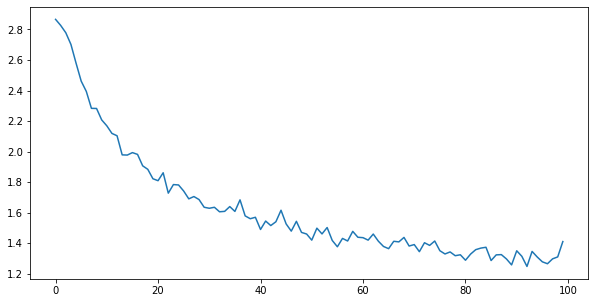

In [13]:
plt.figure(figsize = (10,5))
plt.plot(all_losses)
plt.show() 

### 결과평가 
네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기위해 모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지를 나타내는 혼동 행열(confusion matrix)을 만듭니다. 혼동 행렬을 계산하기 위해 evaluate() 로 많은 수의 샘플을 네트워크에 실행합니다. evaluate() 은 train () 과 역전파를 빼면 동일합니다.

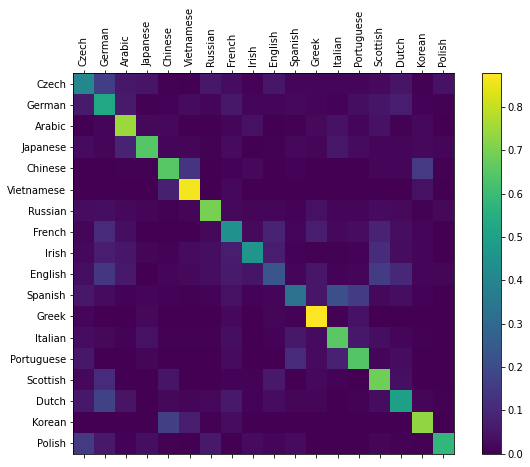

In [16]:
import matplotlib.ticker as ticker
# confusion matrix 


confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환 

def evaluate (line_tensor) :
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]) :
        output, hidden = rnn(line_tensor[i], hidden)
        
        
    return output

# 예시들 중 어떤 것이 정확하게 예측되었는지 기록 

for i in range(n_confusion) :
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output  = evaluate(line_tensor)
    guess , guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] +=1
    
# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')



> Dovesky
(-0.84) Russian
(-0.98) Czech
(-2.51) English

> Jackson
(-0.72) Scottish
(-2.01) Russian
(-2.18) English

> Satoshi
(-0.89) Arabic
(-1.21) Italian
(-2.45) Czech
